In [184]:
import geopandas as gpd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
%matplotlib inline

In [185]:
#Read shapefiles
world_data = gpd.read_file(r's3://ecb-hackathon-data-group08-x19s00/economic_data/regional_boundaries/NUTS_RG_20M_2021_3035.shp') 

In [186]:
nuts3map = world_data[world_data.LEVL_CODE==3]
world_data.head()

NUTS_ID  LEVL_CODE CNTR_CODE     NAME_LATN     NUTS_NAME  MOUNT_TYPE  \
0      FR          0        FR        France        France         0.0   
1      HR          0        HR      Hrvatska      Hrvatska         0.0   
2      HU          0        HU  Magyarország  Magyarország         0.0   
3      AL          0        AL     Shqipëria     Shqipëria         0.0   
4      AT          0        AT    Österreich    Österreich         0.0   

   URBN_TYPE  COAST_TYPE FID  \
0          0           0  FR   
1          0           0  HR   
2          0           0  HU   
3          0           0  AL   
4          0           0  AT   

                                            geometry  
0  MULTIPOLYGON (((9954236.116 -3059379.316, 9961...  
1  MULTIPOLYGON (((4827385.889 2618351.326, 48483...  
2  POLYGON ((5214660.069 2880853.832, 5216710.220...  
3  POLYGON ((5129579.170 2204098.752, 5148385.473...  
4  POLYGON ((4742889.368 2876362.725, 4783217.798...

<h3> Function definitions </h3>

In [201]:




def plotDfAsMap(df):
    #just plot the map
    ax= df.plot(figsize=(10,10))
    #ax=mapDf.plot(cmap='OrRd',column='PC')
    minx, miny, maxx, maxy = 20e5, 10e5, 70e5, 60e5
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.margins(0)
    plt.show()
    
def plotDfAsMapWithColor(df, columnForColor, title_):
    #plot the map but also color code according to a chosen column (column name) from the (geo)dataframe
    ax=df.plot(cmap='RdBu',column=columnForColor, figsize = (8, 8),legend=True,legend_kwds={'shrink': 0.6})
    plt.yticks(color='w')
    plt.xticks(color='w')
    minx, miny, maxx, maxy = 20e5, 10e5, 70e5, 60e5
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(title_)
    ax.margins(0)
   # plt.savefig('figures/Nice looking pictures/SPI1M_PCA_2.png')
    plt.show()



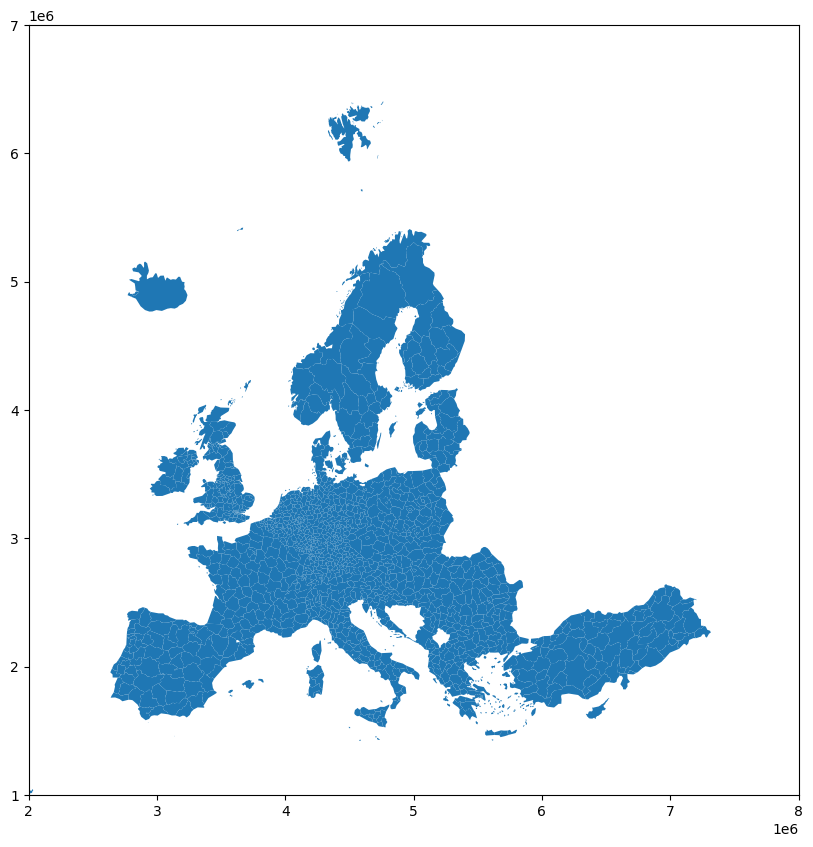

In [188]:
#Only plot NUTS level 3 boundaries

plotDfAsMap(nuts3map)


    

<h2> Now looking at SPI </h2>

<h3> We need to transform the data to Index = year, columns = NUTS_ID:s, and the values are the various SPI-series </h3>

In [189]:
spiData = pd.read_csv('Yohann_spi.csv')

In [190]:
spiData

Unnamed: 0  year NUTS_ID sector  area  employment       gdp  \
0                0  2002   AT111    NaN   NaN         NaN    627.48   
1                1  2002   AT111      A   NaN        1.60    627.48   
2                2  2002   AT111    B-E   NaN        2.50    627.48   
3                3  2002   AT111      C   NaN        2.20    627.48   
4                4  2002   AT111      F   NaN        1.70    627.48   
...            ...   ...     ...    ...   ...         ...       ...   
256795      256795  2018   SK042    M_N   NaN       24.29  10702.43   
256796      256796  2018   SK042    O-Q   NaN       72.62  10702.43   
256797      256797  2018   SK042    O-U   NaN       82.08  10702.43   
256798      256798  2018   SK042    R-U   NaN        9.46  10702.43   
256799      256799  2018   SK042  TOTAL   NaN      294.60  10702.43   

        gross value added  population  MEDIAN_spa01  MEDIAN_spa03  \
0                     NaN       37.73      1.819740      1.875271   
1                   37.00       37.73      1.819740      1.875271   
2                  117.00       37.73      1.819740      1.875271   
3                   92.00       37.73      1.819740      1.875271   
4                   84.00       37.73      1.819740      1.875271   
...                   ...         ...           ...           ...   
256795             937.74      799.60      1.875427      1.938531   
256796            1265.46      799.60      1.875427      1.938531   
256797            1511.59      799.60      1.875427      1.938531   
256798             246.13      799.60      1.875427      1.938531   
256799            9588.14      799.60      1.875427      1.938531   

        MEDIAN_spa06  MEDIAN_spa12  
0           1.920833      1.662865  
1           1.920833      1.662865  
2           1.920833      1.662865  
3           1.920833      1.662865  
4           1.920833      1.662865  
...              ...           ...  
256795      2.185344      2.105354  
256796      2.185344      2.105354  
256797      2.185344      2.105354  
256798      2.185344      2.105354  
256799      2.185344      2.105354  

[256800 rows x 13 columns]

In [191]:
#The spiData have multiple rows for each year and NUTS3 due to many sector rows. I just
#pick one here
spiDataCleaned = spiData[spiData['sector']=='A'][['year','NUTS_ID','MEDIAN_spa01','MEDIAN_spa03','MEDIAN_spa06','MEDIAN_spa12']].copy()

In [192]:
spiDataCleaned.head()

year NUTS_ID  MEDIAN_spa01  MEDIAN_spa03  MEDIAN_spa06  MEDIAN_spa12
1   2002   AT111      1.819740      1.875271      1.920833      1.662865
10  2002   AT112      1.853833      1.926146      1.995771      1.801677
19  2002   AT113      1.808292      1.849073      1.873521      1.580688
28  2002   AT121      1.933188      2.108698      2.231188      2.103104
37  2002   AT122      1.870458      1.974510      2.053729      1.879813

In [193]:

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') #need to impute some missing values

def getSingleSpiSeriesTemporal(columnName):
    #Make a transformed Table for a specific SPI series (there are 1M, 3M, 6M, and 12M series)
    ret = spiDataCleaned[['year','NUTS_ID',columnName]]
    ret = ret.pivot(index='year',columns='NUTS_ID',values=columnName).copy()
    d=ret.isnull().sum()
    ret.drop(columns=d[d>1].index, inplace=True) #drop series with more than 1 missing value (all those are 17 missing)
    ret = pd.DataFrame(index=ret.index, data = imp_mean.fit_transform(ret), columns=ret.columns) #impute other missing
    return ret

#Create the temporal series for each variable

spa01=getSingleSpiSeriesTemporal('MEDIAN_spa01')
spa03=getSingleSpiSeriesTemporal('MEDIAN_spa03')
spa06=getSingleSpiSeriesTemporal('MEDIAN_spa06')
spa12=getSingleSpiSeriesTemporal('MEDIAN_spa12')

spa01.head()

NUTS_ID     AT111     AT112     AT113     AT121     AT122     AT123     AT124  \
year                                                                            
2002     1.819740  1.853833  1.808292  1.933188  1.870458  1.911146  1.943688   
2003     1.447177  1.425135  1.429354  1.459542  1.455271  1.482229  1.468292   
2004     1.691667  1.701719  1.735354  1.709104  1.697292  1.716573  1.717292   
2005     1.996698  1.998594  1.978417  1.999292  2.009688  2.002781  2.003396   
2006     1.764677  1.788458  1.766625  1.794854  1.778396  1.798844  1.784688   

NUTS_ID     AT125     AT126     AT127  ...     SI043     SI044     SK010  \
year                                   ...                                 
2002     1.876437  1.894062  1.886083  ...  1.853302  1.851625  1.870313   
2003     1.484687  1.464042  1.454312  ...  1.435844  1.408250  1.415854   
2004     1.687542  1.703021  1.700187  ...  1.755937  1.746396  1.698938   
2005     2.022937  2.019708  2.011146  ...  1.831385  1.879042  2.046552   
2006     1.800021  1.807187  1.799688  ...  1.698042  1.715292  1.829021   

NUTS_ID     SK021     SK022     SK023     SK031     SK032     SK041     SK042  
year                                                                           
2002     1.848333  1.837740  1.842750  1.836740  1.822073  1.760812  1.769260  
2003     1.407271  1.412708  1.401063  1.458521  1.413958  1.460000  1.425135  
2004     1.711521  1.705563  1.730375  1.698292  1.734667  1.724500  1.746958  
2005     2.044427  2.039510  2.031208  2.026521  2.003292  2.013479  1.997417  
2006     1.817573  1.820688  1.763062  1.761208  1.732969  1.749688  1.766646  

[5 rows x 1163 columns]

<h3> Now, do PCA on the series and see what comes out </h3>


PCA components for SPA01


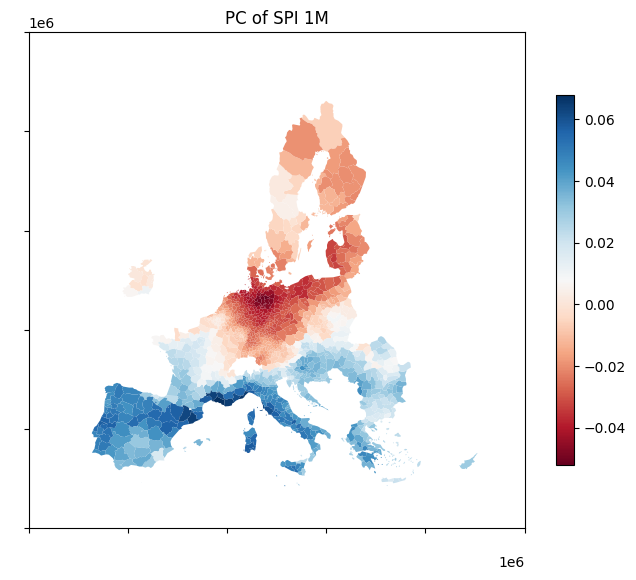

[0.81408929 0.87850088 0.90601842 0.92807021 0.94336331]
PCA components for SPA03


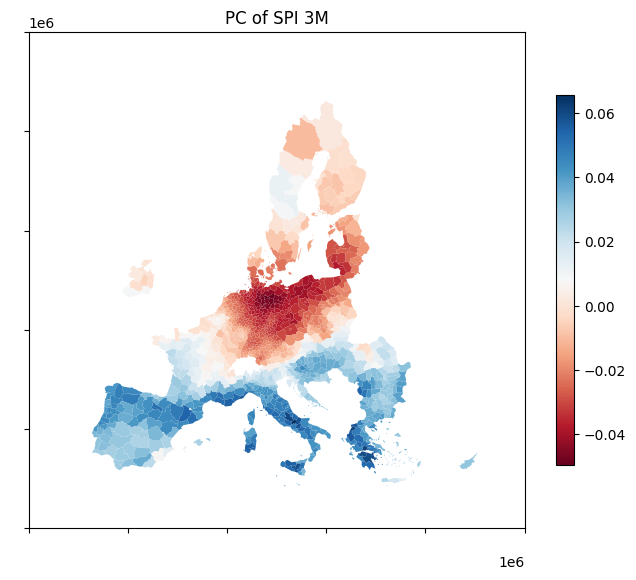

[0.75651336 0.84526298 0.87739399 0.90024453 0.91926531]
PCA components for SPA06


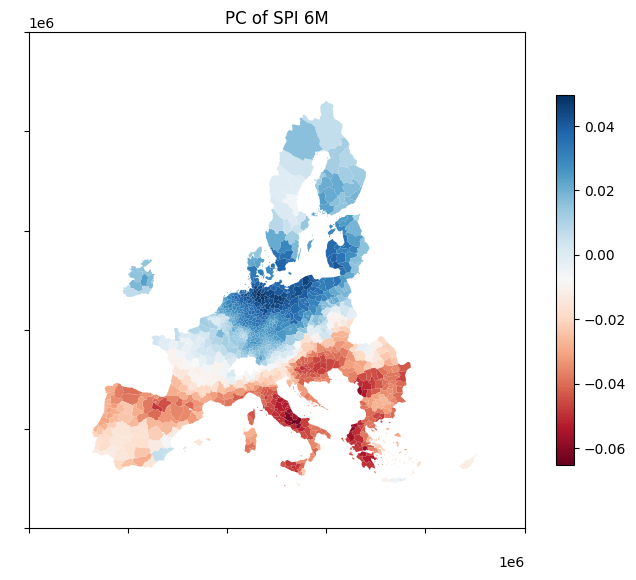

[0.66423291 0.77462158 0.82046883 0.8517381  0.88087948]
PCA components for SPA12


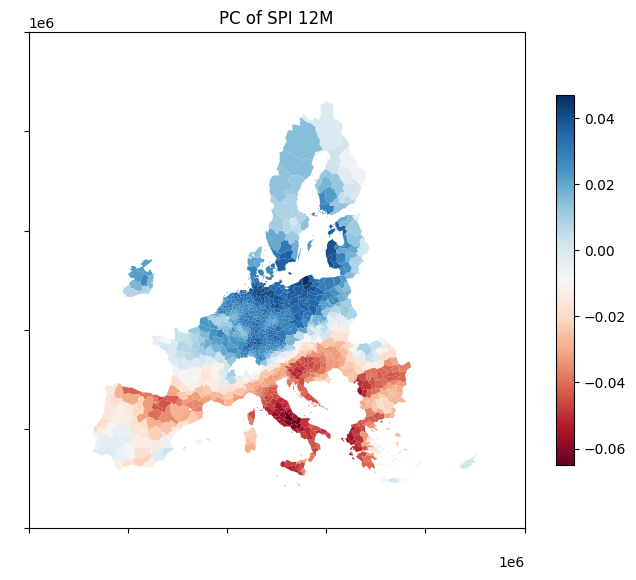

[0.6454552  0.75679345 0.81102362 0.85289041 0.88324052]


In [200]:

def plotPCA_ComponentsOnMap(YearsNutsTable, title_):
    #take a table with year as index, and NUTS-columns. Values could be any series
    #and plot the first 5 PCA components on color coded maps
    #returns the components and projections
    pca = PCA(n_components=5)
    pcaTransformed = pca.fit_transform(YearsNutsTable)
    pcaDf = pd.DataFrame(data=pca.components_.T[:,:5],columns=['PC1_SPI','PC2_SPI','PC3_SPI','PC4_SPI','PC5_SPI'])
    #plt.plot(pca.components_[0])
    pcaDf['NUTS_ID']=YearsNutsTable.columns.values
    plotDf = pd.merge(nuts3map,pcaDf)
    plotDfAsMapWithColor(plotDf,'PC1_SPI', title_)
    plotDfAsMapWithColor(plotDf,'PC2_SPI', title_)
    plotDfAsMapWithColor(plotDf,'PC3_SPI', title_)
    plotDfAsMapWithColor(plotDf,'PC4_SPI', title_)
    plotDfAsMapWithColor(plotDf,'PC5_SPI', title_)
    print(np.cumsum(pca.explained_variance_ratio_))
    return pca.components_, pcaTransformed


print('PCA components for SPA01')
SPA1components, SPA1projs = plotPCA_ComponentsOnMap(spa01,'PC of SPI 1M')

print('PCA components for SPA03')
components, projs = plotPCA_ComponentsOnMap(spa03,'PC of SPI 3M')

print('PCA components for SPA06')
components, projs = plotPCA_ComponentsOnMap(spa06,'PC of SPI 6M')

print('PCA components for SPA12')
components, projs = plotPCA_ComponentsOnMap(spa12,'PC of SPI 12M')

#plotDf = pd.merge(nuts3map,pcaDf)

#pca = PCA(n_components=5)
#pcaTransformedSPI = pca.fit_transform(spa01)

#pcaDf = pd.DataFrame(data=pca.components_.T[:,:5],columns=['PC1_SPI','PC2_SPI','PC3_SPI','PC4_SPI','PC5_SPI'])
#plt.plot(pca.components_[0])
#pcaDf['NUTS_ID']=spa01.columns.values

#plotDf = pd.merge(nuts3map,pcaDf)
#plotDfAsMapWithColor(plotDf,'PC1_SPI')
#plotDfAsMapWithColor(plotDf,'PC2_SPI')

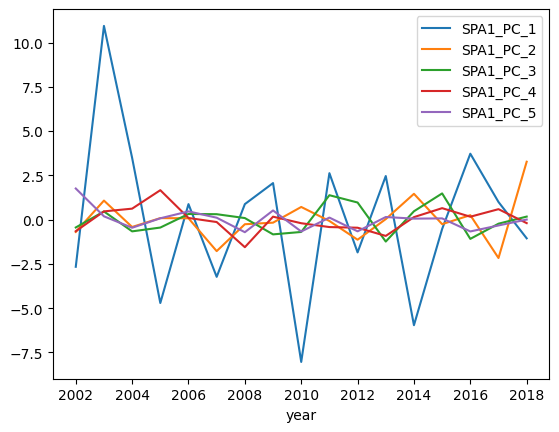

In [183]:
#Save SPA1_PC_Projections in file

spaPCAdf = pd.DataFrame(index=spa01.index, data = SPA1projs, columns=['SPA1_PC_1','SPA1_PC_2','SPA1_PC_3','SPA1_PC_4','SPA1_PC_5'])
#plt.plot(SPA1projs)
spaPCAdf.plot()
spaPCAdf.to_csv('5_PCA_instead_Of_SPI_Johan.csv')

In [158]:
print(pca.explained_variance_ratio_)

[0.81408929 0.06441159 0.02751754 0.02205179 0.01529309]
